<a href="https://colab.research.google.com/github/Elmehdidebug/Improving-learning-from-imbalanced-data-using-CGANs-Credit-card-fraud-detection-case-study/blob/main/Fraud_detection_notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score, confusion_matrix,f1_score, roc_auc_score, roc_curve, precision_recall_curve, auc, balanced_accuracy_score, fbeta_score, recall_score, precision_score
from sklearn.preprocessing import RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest, chi2 , SelectPercentile , f_classif
from sklearn.metrics import accuracy_score
import random
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.linear_model import LogisticRegression, LogisticRegressionCV
from sklearn.ensemble import RandomForestClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import GridSearchCV
from imblearn.under_sampling import RandomUnderSampler
from collections import Counter
import xgboost as xgb
from sklearn.feature_selection import SelectFromModel
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from utils_fraud import fit_score,variance, correlation, randomForestSelector, Anova, gridSearch,randomForestSelectorRanges, plotHistory
from cgans import cGAN
from imblearn.over_sampling import SMOTE

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, MaxPooling1D, Conv1D, LSTM
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
from sklearn.metrics import average_precision_score, confusion_matrix

In [ ]:
!pip install -q -U keras-tuner

In [ ]:
import warnings
warnings.filterwarnings("ignore")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = pd.read_csv('train.csv')
data.head()

,ID,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,1,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,2,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,3,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,4,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,5,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [ ]:
data.shape

(198365, 32)

In [ ]:
testData = pd.read_csv('/content/drive/MyDrive/creditcard.csv')
testData.shape

(284807, 31)

In [ ]:
X_train_ori, X_test_ori, y_train_ori, y_test_ori = train_test_split(testData.drop(['Class'], axis=1), testData['Class'], test_size=0.3, random_state=42, stratify = testData['Class'])

## create test  data

In [ ]:
data_class_fraud=data.loc[data['Class'] == 1]
data_class_fraud.shape

(383, 32)

In [ ]:
data_class_nnfraud=data.loc[data['Class'] == 0]
data_class_nnfraud.shape

(197982, 32)

## Normalizing data using RobustScaler

In [ ]:
data_train = data.copy()
data_test = testData.copy()

In [ ]:
rob_scaler = RobustScaler()
scaled_amount = rob_scaler.fit_transform(data_train['Amount'].values.reshape(-1,1))
scaled_amount_test = rob_scaler.transform(X_test_ori['Amount'].values.reshape(-1,1))
scaled_time = rob_scaler.fit_transform(data_train['Time'].values.reshape(-1,1))
scaled_time_test = rob_scaler.transform(X_test_ori['Time'].values.reshape(-1,1))
data_train.insert(0, 'scaled_amount', scaled_amount)
data_train.insert(1, 'scaled_time', scaled_time)
data_train.drop(['Time','Amount'], axis=1, inplace=True)
X_test_ori.insert(0, 'scaled_amount', scaled_amount_test)
X_test_ori.insert(1, 'scaled_time', scaled_time_test)
X_test_ori.drop(['Time','Amount'], axis=1, inplace=True)
data_train.head()

,scaled_amount,scaled_time,ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.729682,-1.454417,1,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,0.090794,-0.551600,-0.617801,-0.991390,-0.311169,1.468177,-0.470401,0.207971,0.025791,0.403993,0.251412,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,0
1,-0.277285,-1.454417,2,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,-0.166974,1.612727,1.065235,0.489095,-0.143772,0.635558,0.463917,-0.114805,-0.183361,-0.145783,-0.069083,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,0
2,4.858216,-1.454395,3,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,0.207643,0.624501,0.066084,0.717293,-0.165946,2.345865,-2.890083,1.109969,-0.121359,-2.261857,0.524980,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,0
3,1.372900,-1.454395,4,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,-0.054952,-0.226487,0.178228,0.507757,-0.287924,-0.631418,-1.059647,-0.684093,1.965775,-1.232622,-0.208038,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,0
4,0.641989,-1.454374,5,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,0.753074,-0.822843,0.538196,1.345852,-1.119670,0.175121,-0.451449,-0.237033,-0.038195,0.803487,0.408542,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,0


<h1>Random under sampling</h1>
<p>We will use the random undersampler function to balance our data</p>

In [ ]:
X_train_origin = data_train.drop('Class', axis=1)
Y_train_origin = data_train['Class']

In [ ]:
# define undersample strategy
undersample = RandomUnderSampler(sampling_strategy='majority',random_state=4)
# fit and apply the transform
X_RF, Y_RF = undersample.fit_resample(X_train_origin, Y_train_origin)
X_RF= pd.DataFrame(X_RF,columns=X_train_origin.columns)
del X_RF['ID']
Y_RF= pd.DataFrame(Y_RF,columns=['Class'])
rus_df = pd.concat([X_RF, Y_RF],axis=1, sort=False)
rus_df

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
0,1.270455,1.390970,1.801857,-0.660489,-0.404553,0.391980,-0.772806,-0.627599,-0.331003,-0.144684,0.996165,-0.072725,-0.817066,0.686434,0.788603,-0.213523,0.489627,0.469815,-0.596899,-0.431520,-0.057438,0.073518,-0.153612,-0.539188,0.301766,-0.093106,-0.637226,0.267047,-0.051107,-0.023999,0
1,-0.040841,-0.295854,1.299566,-0.140147,0.266892,-0.213047,-0.503021,-0.616222,-0.237390,-0.092331,0.526387,-0.203767,-0.968449,-0.308736,-0.292023,0.200165,1.367567,0.645704,-0.595306,-0.111089,0.299666,-0.040924,-0.177216,-0.561200,-0.001407,-0.292457,0.189143,0.949279,-0.078663,0.004019,0
2,3.478623,1.350423,1.562831,-1.180869,-2.124060,-0.733167,-0.036954,-0.821904,0.544786,-0.295556,0.556521,-0.244249,1.088466,0.885773,-0.437210,0.829501,-0.045820,-0.326500,-0.340008,-0.065690,0.580952,0.366156,0.271245,0.256073,-0.130104,0.791177,-0.043111,0.670341,-0.164303,-0.035150,0
3,-0.105177,0.120447,1.022084,-0.419514,0.665215,0.257751,0.398302,2.737510,-1.031485,0.851143,0.625991,-0.284464,1.001679,1.494776,0.796060,-0.298804,0.596706,-0.599265,0.314863,-1.389868,-0.869046,-0.130690,0.014896,0.378652,-0.012314,-2.130219,0.086590,0.497486,0.086463,-0.006939,0
4,-0.303647,-0.966746,1.265567,-0.470439,1.009771,-0.989664,-1.279999,-0.742026,-0.733799,-0.093846,3.549195,-1.712291,0.283526,-1.590198,1.366323,1.035526,-0.386705,-0.948957,1.049939,-0.003821,0.974567,-0.167263,-0.341420,-0.357936,0.012986,0.364588,0.411956,-0.221131,0.030578,0.016862,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
761,-0.300369,1.361754,-1.396204,2.618584,-6.036770,3.552454,1.030091,-2.950358,-1.528506,0.189319,-1.433554,-5.569142,3.277546,-5.896937,-1.277102,-11.221805,0.326027,-2.497341,-1.588336,0.120289,0.170144,0.031795,0.143177,-0.390176,0.356029,-0.762352,0.096510,-0.487861,0.062655,-0.240732,1
762,4.638164,1.362253,-2.434004,3.225947,-6.596282,3.593161,-1.079452,-1.739741,-0.047420,0.301424,-1.779434,-5.836453,3.249431,-5.961488,-1.155176,-11.002289,0.588286,-2.365801,-1.351900,0.189498,0.524008,-0.280533,-0.035491,-0.419178,0.157436,-0.714849,0.468859,-0.348522,0.420036,-0.327643,1
763,3.458271,1.363208,1.522080,-0.519429,-2.581685,0.774741,0.206722,-1.431020,0.757011,-0.444418,0.997921,-1.429490,-0.375466,0.179095,-0.148449,-2.135155,-0.044916,-0.055333,1.778697,0.671832,-0.002021,0.361169,0.019649,-0.211678,-0.247452,-0.279472,0.239646,-0.508398,-0.015551,0.041881,1
764,9.564540,1.389603,0.469750,-1.237555,-1.767341,4.833490,-0.268715,-0.512760,1.140149,-0.341273,-1.046351,0.085662,-0.000121,-0.054381,0.736192,-2.306645,-0.464003,1.672723,1.165737,0.561323,-2.300798,1.277315,0.303905,-0.647075,-0.373014,0.260801,-0.496566,-0.245973,-0.117858,0.144774,1


In [ ]:
Y_RF.value_counts()

Class
1        383
0        383
dtype: int64

## Feature selection

in order to choose the best features we decide to use data passed by underSampling, because finding the features required balanced data, so if we choose the oversampling data we will get more than 380K samples, which is cost a lot.

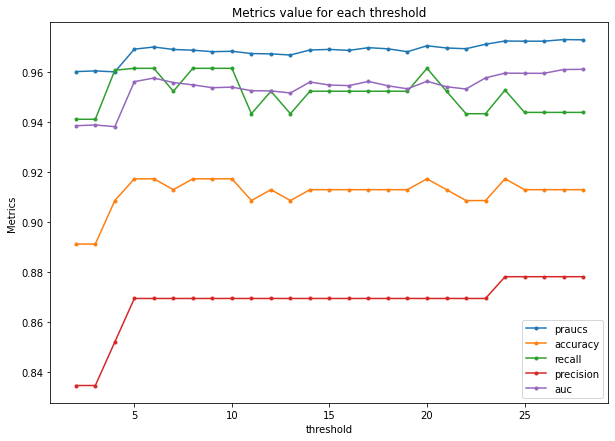

In [ ]:
#use the randomForestSelector function to select the best features
randomForestFeatures = randomForestSelectorRanges(X_RF, Y_RF, 2,29)

The best number of features is 24 features, because our goal here is to find the best value of auc and recall metrics.

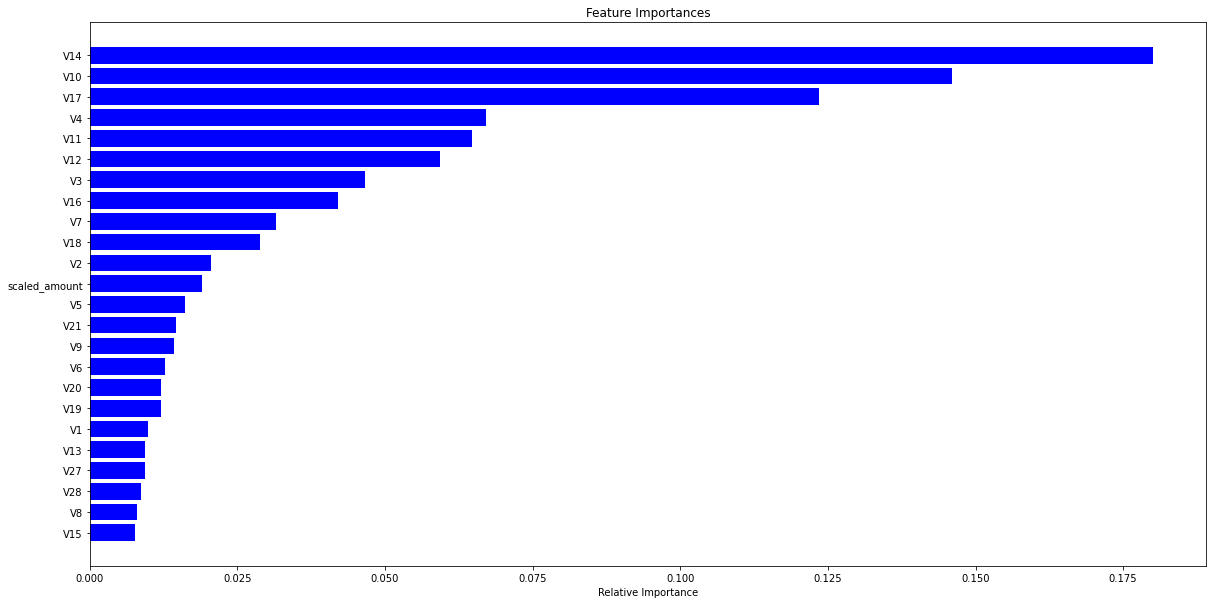

,V15,V8,V28,V27,V13,V1,V19,V20,V6,V9,V21,V5,scaled_amount,V2,V18,V7,V16,V3,V12,V11,V4,V17,V10,V14
0,0.489627,-0.144684,-0.023999,-0.051107,0.788603,1.801857,-0.057438,0.073518,-0.627599,0.996165,-0.153612,-0.772806,1.270455,-0.660489,-0.431520,-0.331003,0.469815,-0.404553,0.686434,-0.817066,0.391980,-0.596899,-0.072725,-0.213523
1,1.367567,-0.092331,0.004019,-0.078663,-0.292023,1.299566,0.299666,-0.040924,-0.616222,0.526387,-0.177216,-0.503021,-0.040841,-0.140147,-0.111089,-0.237390,0.645704,0.266892,-0.308736,-0.968449,-0.213047,-0.595306,-0.203767,0.200165
2,-0.045820,-0.295556,-0.035150,-0.164303,-0.437210,1.562831,0.580952,0.366156,-0.821904,0.556521,0.271245,-0.036954,3.478623,-1.180869,-0.065690,0.544786,-0.326500,-2.124060,0.885773,1.088466,-0.733167,-0.340008,-0.244249,0.829501
3,0.596706,0.851143,-0.006939,0.086463,0.796060,1.022084,-0.869046,-0.130690,2.737510,0.625991,0.014896,0.398302,-0.105177,-0.419514,-1.389868,-1.031485,-0.599265,0.665215,1.494776,1.001679,0.257751,0.314863,-0.284464,-0.298804
4,-0.386705,-0.093846,0.016862,0.030578,1.366323,1.265567,0.974567,-0.167263,-0.742026,3.549195,-0.341420,-1.279999,-0.303647,-0.470439,-0.003821,-0.733799,-0.948957,1.009771,-1.590198,0.283526,-0.989664,1.049939,-1.712291,1.035526
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
761,0.326027,0.189319,-0.240732,0.062655,-1.277102,-1.396204,0.170144,0.031795,-2.950358,-1.433554,0.143177,1.030091,-0.300369,2.618584,0.120289,-1.528506,-2.497341,-6.036770,-5.896937,3.277546,3.552454,-1.588336,-5.569142,-11.221805
762,0.588286,0.301424,-0.327643,0.420036,-1.155176,-2.434004,0.524008,-0.280533,-1.739741,-1.779434,-0.035491,-1.079452,4.638164,3.225947,0.189498,-0.047420,-2.365801,-6.596282,-5.961488,3.249431,3.593161,-1.351900,-5.836453,-11.002289
763,-0.044916,-0.444418,0.041881,-0.015551,-0.148449,1.522080,-0.002021,0.361169,-1.431020,0.997921,0.019649,0.206722,3.458271,-0.519429,0.671832,0.757011,-0.055333,-2.581685,0.179095,-0.375466,0.774741,1.778697,-1.429490,-2.135155
764,-0.464003,-0.341273,0.144774,-0.117858,0.736192,0.469750,-2.300798,1.277315,-0.512760,-1.046351,0.303905,-0.268715,9.564540,-1.237555,0.561323,1.140149,1.672723,-1.767341,-0.054381,-0.000121,4.833490,1.165737,0.085662,-2.306645


In [ ]:
randomForestFeatures = randomForestSelector(X_RF, Y_RF, 24)
data_featured = X_RF.loc[:, randomForestFeatures]
data_featured

## Base models

We will use multiple algorithms for in our experimentals : 
<ul>
<li>
  Supervised : 
  
  LogisticRegression

  XGBClassifier

  RandomForestClassifier

  ANN

  1dCNN + LSTM
</li>
<li>
  Unsupervised : 
  
  IsolationForest

  OneClassSVM
</li>
</ul>

In [ ]:
models = [
          {
            "Model":LogisticRegression(random_state=0),
            "params" : {"C":[0.001,0.01,0.1,1,10,100], "penalty":["l1","l2"]}
          },
          {
            "Model":xgb.XGBClassifier(objective= 'binary:logistic',nthread=4,random_state=0),
            "params" : {'max_depth': range (2, 10, 1),'n_estimators': range(60, 220, 40), 
                        'learning_rate': [0.1, 0.01, 0.05]}
          },
          {
            "Model":RandomForestClassifier(random_state=0),
            "params" : {'bootstrap': [True, False], 'max_depth': [10, 20, 30, 40], 
                         'min_samples_split': [2, 5, 10], 'n_estimators': [100, 200, 500]}        
          }
        ]
##Unsupervised

classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, 
                                       contamination=0.1,random_state=0, verbose=0),
    "Support Vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.01, 
                                         max_iter=-1)
   
}

### Training
Before finding the best model be device the data into train_set and test_set, and after find it we trained the model with all data for submitting in kaggle.

The results below based in all data, to show the performance we will test with the train data, because the test data is not labeled.

In [ ]:
#test with a fraction of data
data_frac = data_train.sample(frac =.1)
data_frac.shape

(19836, 32)

# We apply unsupervised model for outliers detection

We choose 1% of data for computational reasons

In [ ]:
columns = data_frac.columns.tolist()
# Filter the columns to remove data we do not want 
columns = [c for c in columns if c not in ["Class"]]
# Store the variable we are predicting 
target = "Class"
# Define a random state 
state = np.random.RandomState(42)
X_outliers = data_frac[columns]
Y_outliers = data_frac[target]
X_outliers = state.uniform(low=0, high=1, size=(X_outliers.shape[0], X_outliers.shape[1]))
# Print the shapes of X & Y
print(X_outliers.shape)
print(Y_outliers.shape)

(19836, 31)
(19836,)


we compute the outlier fraction for the contamination hyperparam

In [ ]:
Fraud = data_frac[data_frac['Class']==1]

Valid = data_frac[data_frac['Class']==0]

outlier_fraction = (len(Fraud)/float(len(Valid)))*100
print('number of fraud in 1% of dataset :', Fraud.shape)
print('number of valid in 1% of dataset :', Valid.shape)
print('outlier_fraction:' , outlier_fraction,'% of the dataset')

number of fraud in 1% of dataset : (34, 32)
number of valid in 1% of dataset : (19802, 32)
outlier_fraction: 0.17169982830017172 % of the dataset


We choose Isolation Forest  and Support Vector Machine

In [ ]:
train_valid,test_valid = train_test_split(Valid.drop(['Class'],axis=1) , test_size=0.3, random_state=0)

outliers=Fraud.drop(['Class'],axis=1)

In [ ]:
n_outliers = len(Fraud)
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Isolation Forest":
        clf.fit(train_valid)
        y_pred_outliers= clf.predict(outliers)
        y_pred_valid= clf.predict(test_valid)
    else:
        clf.fit(train_valid)
        y_pred_outliers= clf.predict(outliers)
        y_pred_valid= clf.predict(test_valid)
    # Run Classification Metrics
    print('******')
    print(clf_name)
    print("Accuracy in Detecting Legit Cases:", list(y_pred_valid).count(1)/y_pred_valid.shape[0])
    print("Accuracy in Detecting Fraud Cases:", list(y_pred_outliers).count(-1)/y_pred_outliers.shape[0])

******
Isolation Forest
Accuracy in Detecting Legit Cases: 0.9015317286652079
Accuracy in Detecting Fraud Cases: 0.9117647058823529
******
Support Vector Machine
Accuracy in Detecting Legit Cases: 0.0
Accuracy in Detecting Fraud Cases: 1.0


## Outliers detectors using feature selection

In [ ]:
train_valid,test_valid = train_test_split(Valid.drop(['Class'],axis=1).loc[:, randomForestFeatures] , test_size=0.3, random_state=0)

outliers=Fraud.drop(['Class'],axis=1).loc[:, randomForestFeatures]

In [ ]:
n_outliers = len(Fraud)
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Isolation Forest":
        clf.fit(train_valid)
        y_pred_outliers= clf.predict(outliers)
        y_pred_valid= clf.predict(test_valid)
    else:
        clf.fit(train_valid)
        y_pred_outliers= clf.predict(outliers)
        y_pred_valid= clf.predict(test_valid)
    # Run Classification Metrics
    print('******')
    print(clf_name)
    print("Accuracy in Detecting Legit Cases:", list(y_pred_valid).count(1)/y_pred_valid.shape[0])
    print("Accuracy in Detecting Fraud Cases:", list(y_pred_outliers).count(-1)/y_pred_outliers.shape[0])

******
Isolation Forest
Accuracy in Detecting Legit Cases: 0.8979969702070358
Accuracy in Detecting Fraud Cases: 0.9117647058823529
******
Support Vector Machine
Accuracy in Detecting Legit Cases: 0.8798182124221512
Accuracy in Detecting Fraud Cases: 0.9117647058823529


#Supervised Algorithms
To test if features seletion has an impact or not we will test with both cases, without and with.

## UnderSampling : RandomUnderSampling

###  score without features selection, only RUS

In [ ]:
X_test_ori.head(1)

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
186882,0.196831,1.308639,-2.537331,1.890864,-0.840555,-1.102759,-2.105725,0.367811,-2.737844,-3.543314,-0.483147,0.112724,-1.612586,0.635855,0.406871,0.854371,0.505753,-0.947788,0.557331,1.546638,-0.789047,-1.959611,4.328165,-2.167329,1.022567,-0.241143,-1.094885,-0.475427,-0.177157,-0.082691


In [ ]:
X_RF.head(1)

,scaled_amount,scaled_time,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28
0,1.270455,1.39097,1.801857,-0.660489,-0.404553,0.39198,-0.772806,-0.627599,-0.331003,-0.144684,0.996165,-0.072725,-0.817066,0.686434,0.788603,-0.213523,0.489627,0.469815,-0.596899,-0.43152,-0.057438,0.073518,-0.153612,-0.539188,0.301766,-0.093106,-0.637226,0.267047,-0.051107,-0.023999


In [ ]:
grid_models =gridSearch(X_RF,Y_RF, models)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.5s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   15.8s
[Parallel(n_jobs=-1)]: Done 258 tasks      | elapsed:   54.7s
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  1.9min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   20.0s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.5min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  3.0min finished


Model name :  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Best Parameters {'C': 0.1, 'penalty': 'l2'}
AUC-score : [0.973399790552027]
Precision-Recall-auc:  [0.5563380182718416]
Balanced accuracy score [0.9183617508709836]
Recall : [0.8581081081081081]
Precision : [0.06509482316760636]
F1_score [0.12101000476417341]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85295
           1       0.07      0.86      0.12       148

    accuracy                           0.98     85443
   macro avg       0.53      0.92      0.56     85443
weighted avg       1.00      0.98      0.99     85443

[[83471  1824]
 [   21   127]]


roc_curve:


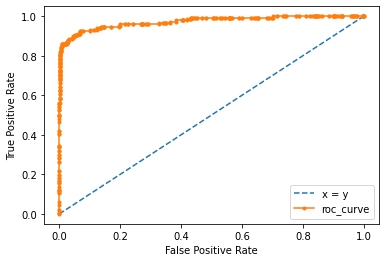



prauc_curve:


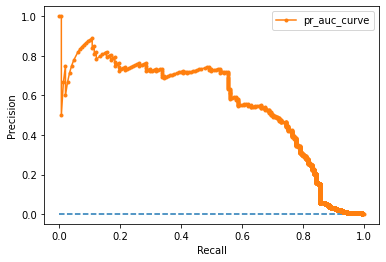

********
Model name :  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
Best Parameters {'learning_rate': 0.05, 'max_depth': 5, 'n_estimators': 60}
AUC-score : [0.9904470256645062]
Precision-Recall-auc:  [0.8169049795349443]
Balanced accuracy score [0.9515065757474457]
Recall : [0.9256756756756757]
Precision : [0.06618357487922705]
F1_score [0.12353471596032461]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85295
           1       0.07      0.93      0.12       148

    accuracy                           0.98     85443

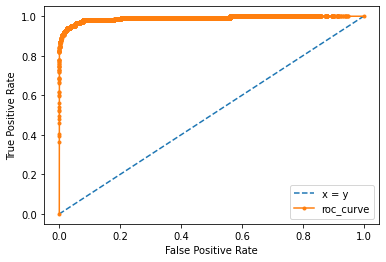



prauc_curve:


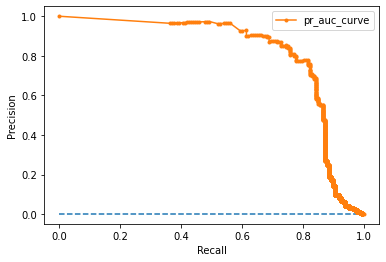

********
Model name :  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
Best Parameters {'bootstrap': False, 'max_depth': 10, 'min_samples_split': 2, 'n_estimators': 200}
AUC-score : [0.9927613703157404]
Precision-Recall-auc:  [0.9045942729695844]
Balanced accuracy score [0.9651706398936599]
Recall : [0.9459459459459459]
Precision : [0.09517335146159075]
F1_score [0.17294626312538602]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85295
        

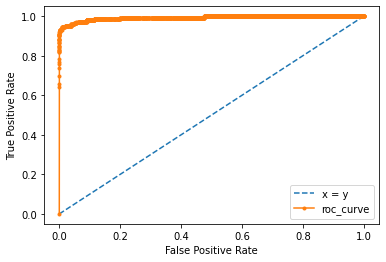



prauc_curve:


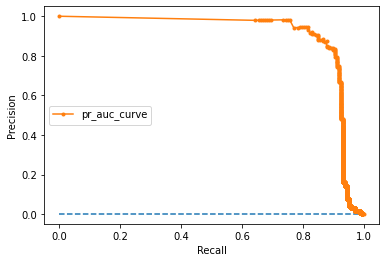

********
GridSearchCV(cv=5, error_score=nan,
             estimator=XGBClassifier(base_score=0.5, booster='gbtree',
                                     colsample_bylevel=1, colsample_bynode=1,
                                     colsample_bytree=1, gamma=0,
                                     learning_rate=0.1, max_delta_step=0,
                                     max_depth=3, min_child_weight=1,
                                     missing=None, n_estimators=100, n_jobs=1,
                                     nthread=4, objective='binary:logistic',
                                     random_state=0, reg_alpha=0, reg_lambda=1,
                                     scale_pos_weight=1, seed=None, silent=None,
                                     subsample=1, verbosity=1),
             iid='deprecated', n_jobs=-1,
             param_grid={'learning_rate': [0.1, 0.01, 0.05],
                         'max_depth': range(2, 10),
                         'n_estimators': range(60, 220, 40)}

In [ ]:
for i in range(len(models)):
  print("Model name : ", models[i]["Model"])
  fit_score(grid_models[i], X_test_ori, y_test_ori)
  print("********")
print(grid_models[1])

### Score with feature selection and RUS

In [ ]:
data_featured.shape

(766, 24)

#### GridSearch

In [ ]:
grid_models =gridSearch(data_featured,Y_RF, models)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    0.4s finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Done  88 tasks      | elapsed:   13.9s
[Parallel(n_jobs=-1)]: Done 318 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed:  1.7min finished
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed:  2.6min finished


Model name :  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Best Parameters {'C': 0.1, 'penalty': 'l2'}
AUC-score : [0.9731722812559908]
Precision-Recall-auc:  [0.548230302255531]
Balanced accuracy score [0.9174531395807555]
Recall : [0.8581081081081081]
Precision : [0.06030389363722697]
F1_score [0.11268855368234251]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85295
           1       0.06      0.86      0.11       148

    accuracy                           0.98     85443
   macro avg       0.53      0.92      0.55     85443
weighted avg       1.00      0.98      0.99     85443

[[83316  1979]
 [   21   127]]


roc_curve:


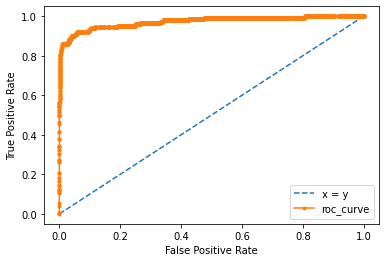



prauc_curve:


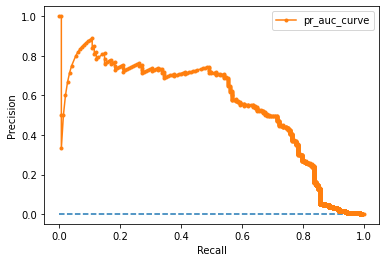


Model name :  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
Best Parameters {'learning_rate': 0.05, 'max_depth': 8, 'n_estimators': 60}
AUC-score : [0.9918764050996304]
Precision-Recall-auc:  [0.8089712551019826]
Balanced accuracy score [0.9635663111965944]
Recall : [0.9527027027027027]
Precision : [0.060723514211886306]
F1_score [0.11417004048582995]
              precision    recall  f1-score   support

           0       1.00      0.97      0.99     85295
           1       0.06      0.95      0.11       148

    accuracy                           0.97     85443
   mac

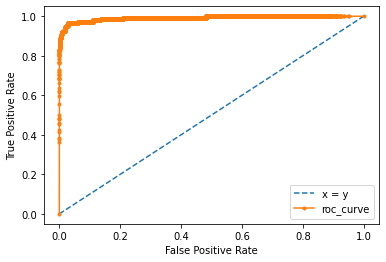



prauc_curve:


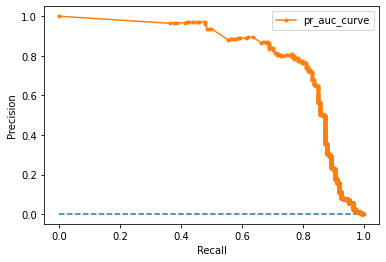


Model name :  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
Best Parameters {'bootstrap': True, 'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 500}
AUC-score : [0.9936354432866537]
Precision-Recall-auc:  [0.8371332886849463]
Balanced accuracy score [0.9660909752005362]
Recall : [0.9459459459459459]
Precision : [0.106544901065449]
F1_score [0.19151846785225718]
              precision    recall  f1-score   support

           0       1.00      0.99      0.99     85295
           1       

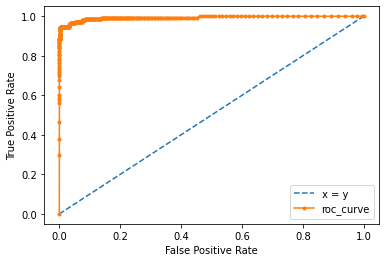



prauc_curve:


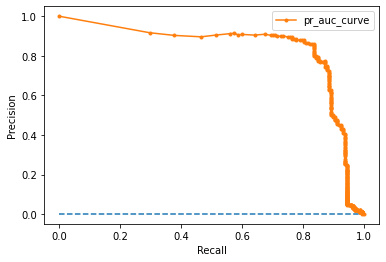

In [ ]:
for i in range(len(models)):
  print("Model name : ", models[i]["Model"])
  fit_score(grid_models[i], X_test_ori.loc[:, randomForestFeatures], y_test_ori)
  print("")

### Use ANN with undersampling and RF feature selection

In [ ]:
x_train_nn, x_test_nn, y_train_nn, y_test_nn = train_test_split(data_featured, Y_RF, test_size=0.3, stratify=Y_RF, random_state=0)

#### Keras tuner for NN gridsearch

In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch

In [ ]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Dense(units=hp.Int('units',
                                        min_value=32,
                                        max_value=512,
                                        step=32),
                           activation='relu', input_dim=(x_train_nn.shape[1])))
    for i in range(hp.Int('n_layers', 1, 8)):
        model.add(layers.Dense(hp.Int(f'conv_{i}_units',
                                min_value=32,
                                max_value=256,
                                step=32), activation="relu"))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate',
                      values=[1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model

In [ ]:
import time
LOG_DIR = f"{int(time.time())}"

In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=2,
    directory='LOG_DIR')

INFO:tensorflow:Reloading Oracle from existing project LOG_DIR/untitled_project/oracle.json
INFO:tensorflow:Reloading Tuner from LOG_DIR/untitled_project/tuner0.json


In [ ]:
tuner.search_space_summary()

Search space summary
Default search space size: 11
units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 512, 'step': 32, 'sampling': None}
n_layers (Int)
{'default': None, 'conditions': [], 'min_value': 1, 'max_value': 8, 'step': 1, 'sampling': None}
conv_0_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}
conv_1_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
conv_2_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
conv_3_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
conv_4_units (Int)
{'default': None, 'conditions': [], 'min_value': 32, 'max_value': 256, 'step': 32, 'sampling': None}
conv_5_units (I

In [ ]:
tuner.search(x_train_nn,
             y_train_nn,
             epochs=20,
             batch_size=64,
             validation_data=(x_test_nn, y_test_nn)
            )

INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.results_summary()

Results summary
Results in LOG_DIR/untitled_project
Showing 10 best trials
Objective(name='val_accuracy', direction='max')
Trial summary
Hyperparameters:
units: 128
n_layers: 5
conv_0_units: 192
learning_rate: 0.01
conv_1_units: 160
conv_2_units: 160
conv_3_units: 160
conv_4_units: 96
conv_5_units: 128
conv_6_units: 64
conv_7_units: 192
Score: 0.9673912823200226
Trial summary
Hyperparameters:
units: 256
n_layers: 8
conv_0_units: 160
learning_rate: 0.01
conv_1_units: 128
conv_2_units: 64
conv_3_units: 64
conv_4_units: 128
conv_5_units: 64
conv_6_units: 160
conv_7_units: 224
Score: 0.9652173817157745
Trial summary
Hyperparameters:
units: 64
n_layers: 4
conv_0_units: 256
learning_rate: 0.001
conv_1_units: 32
conv_2_units: 64
conv_3_units: 224
conv_4_units: 64
conv_5_units: 96
conv_6_units: 192
conv_7_units: 192
Score: 0.9608695805072784
Trial summary
Hyperparameters:
units: 480
n_layers: 4
conv_0_units: 192
learning_rate: 0.01
conv_1_units: 160
conv_2_units: 192
conv_3_units: 96
conv_4_un

In [ ]:
tuner.get_best_models()[0].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 128)               3200      
_________________________________________________________________
dense_1 (Dense)              (None, 192)               24768     
_________________________________________________________________
dense_2 (Dense)              (None, 160)               30880     
_________________________________________________________________
dense_3 (Dense)              (None, 160)               25760     
_________________________________________________________________
dense_4 (Dense)              (None, 160)               25760     
_________________________________________________________________
dense_5 (Dense)              (None, 96)                15456     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 9

In [ ]:
tuner.get_best_hyperparameters()[0].values

{'conv_0_units': 192,
 'conv_1_units': 160,
 'conv_2_units': 160,
 'conv_3_units': 160,
 'conv_4_units': 96,
 'conv_5_units': 128,
 'conv_6_units': 64,
 'conv_7_units': 192,
 'learning_rate': 0.01,
 'n_layers': 5,
 'units': 128}

In [ ]:
# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

In [ ]:
history = best_model.fit(x_train_nn,
             y_train_nn,
             epochs=7,
             batch_size=64,
             validation_data=(x_test_nn, y_test_nn))

Epoch 1/7
9/9 [==============================] - 1s 26ms/step - loss: 0.1194 - accuracy: 0.9571 - val_loss: 0.1967 - val_accuracy: 0.9609
Epoch 2/7
9/9 [==============================] - 0s 7ms/step - loss: 0.0579 - accuracy: 0.9803 - val_loss: 0.2078 - val_accuracy: 0.9609
Epoch 3/7
9/9 [==============================] - 0s 6ms/step - loss: 0.0498 - accuracy: 0.9863 - val_loss: 0.2205 - val_accuracy: 0.9522
Epoch 4/7
9/9 [==============================] - 0s 6ms/step - loss: 0.0613 - accuracy: 0.9817 - val_loss: 0.3359 - val_accuracy: 0.9609
Epoch 5/7
9/9 [==============================] - 0s 7ms/step - loss: 0.0297 - accuracy: 0.9878 - val_loss: 0.4282 - val_accuracy: 0.9565
Epoch 6/7
9/9 [==============================] - 0s 7ms/step - loss: 0.0796 - accuracy: 0.9817 - val_loss: 0.2746 - val_accuracy: 0.9478
Epoch 7/7
9/9 [==============================] - 0s 7ms/step - loss: 0.0679 - accuracy: 0.9846 - val_loss: 0.2553 - val_accuracy: 0.9478


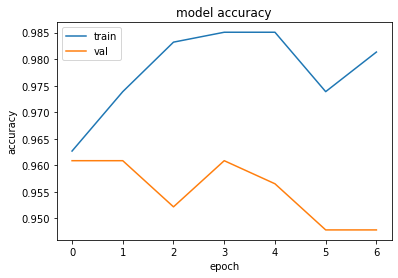

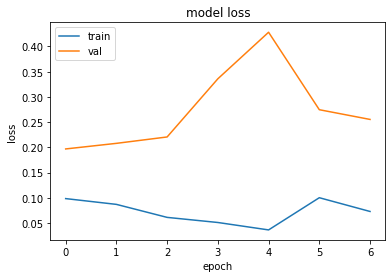

In [ ]:
plotHistory(history, True, True)

In [ ]:
# Evaluate the best model.
loss, accuracy = best_model.evaluate(X_test_ori.loc[:, randomForestFeatures], y_test_ori)

2671/2671 [==============================] - 5s 2ms/step - loss: 0.1152 - accuracy: 0.9500


In [ ]:
print('the accuracy of the model is : ' ,  accuracy)

the accuracy of the model is :  0.9499666690826416


In [ ]:
predict_proba = best_model.predict_proba(X_test_ori.loc[:, randomForestFeatures])

In [ ]:
auc_score = roc_auc_score(y_test_ori, predict_proba)
print("The model prauc_score is {}.".format(auc_score))

The model prauc_score is 0.9815416052079984.


In [ ]:
class_prediction = best_model.predict_classes(X_test_ori.loc[:, randomForestFeatures])

In [ ]:
print(classification_report(y_test_ori, class_prediction))
print(confusion_matrix(y_test_ori, class_prediction))

              precision    recall  f1-score   support

           0       1.00      0.95      0.97     85295
           1       0.03      0.93      0.06       148

    accuracy                           0.95     85443
   macro avg       0.52      0.94      0.52     85443
weighted avg       1.00      0.95      0.97     85443

[[81031  4264]
 [   11   137]]


In [ ]:
y_pred = best_model.predict_classes(X_test_ori.loc[:, randomForestFeatures])
probs_ov=best_model.predict_proba(X_test_ori.loc[:, randomForestFeatures])
roc = roc_auc_score(y_test_ori, probs_ov)
precision, recall,_ = precision_recall_curve(y_test_ori, probs_ov)
prauc = auc(recall, precision)
balanced_acc = balanced_accuracy_score(y_test_ori,y_pred)   
re = recall_score(y_test_ori, y_pred)
pr = precision_score(y_test_ori, y_pred)
f1 = fbeta_score(y_test_ori,y_pred, beta=1.0)

#### LSTM + Conv1d

In [ ]:
X_train=x_train_nn.to_numpy().reshape(x_train_nn.shape[0],x_train_nn.shape[1],1)
X_val_test=x_test_nn.to_numpy().reshape(x_test_nn.shape[0],x_test_nn.shape[1],1)
X_test=X_test_ori.loc[:, randomForestFeatures].to_numpy().reshape(X_test_ori.loc[:, randomForestFeatures].shape[0],X_test_ori.loc[:, randomForestFeatures].shape[1],1)

In [ ]:
y_train=y_train_nn.to_numpy()
y_val_test=y_test_nn.to_numpy()
y_test=y_test_ori.to_numpy()

In [ ]:
model = Sequential()
model.add(Conv1D(32,3,activation='relu',input_shape=X_train[0].shape))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics=['accuracy'])
print(model.summary())

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 22, 32)            128       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 11, 32)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               53200     
_________________________________________________________________
dense_7 (Dense)              (None, 1)                 101       
Total params: 53,429
Trainable params: 53,429
Non-trainable params: 0
_________________________________________________________________
None


In [ ]:
history = model.fit(X_train,y_train,epochs=170,validation_data=(X_val_test,y_val_test))

Epoch 1/170
17/17 [==============================] - 7s 32ms/step - loss: 0.7334 - accuracy: 0.5349 - val_loss: 0.6258 - val_accuracy: 0.9130
Epoch 2/170
17/17 [==============================] - 0s 7ms/step - loss: 0.6113 - accuracy: 0.8895 - val_loss: 0.5431 - val_accuracy: 0.9087
Epoch 3/170
17/17 [==============================] - 0s 7ms/step - loss: 0.5363 - accuracy: 0.8918 - val_loss: 0.4930 - val_accuracy: 0.9043
Epoch 4/170
17/17 [==============================] - 0s 7ms/step - loss: 0.4996 - accuracy: 0.9028 - val_loss: 0.4544 - val_accuracy: 0.9087
Epoch 5/170
17/17 [==============================] - 0s 7ms/step - loss: 0.4549 - accuracy: 0.9174 - val_loss: 0.4201 - val_accuracy: 0.9174
Epoch 6/170
17/17 [==============================] - 0s 7ms/step - loss: 0.4293 - accuracy: 0.9047 - val_loss: 0.3896 - val_accuracy: 0.9174
Epoch 7/170
17/17 [==============================] - 0s 6ms/step - loss: 0.4206 - accuracy: 0.9036 - val_loss: 0.3580 - val_accuracy: 0.9261
Epoch 8/170


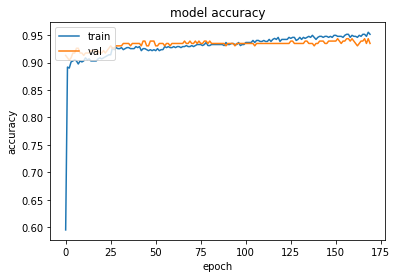

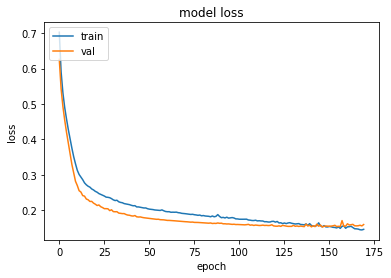

In [ ]:
plotHistory(history, True, True)

In [ ]:
class_prediction = model.predict_classes(X_test)
print(classification_report(y_test, class_prediction))
print(confusion_matrix(y_test, class_prediction))

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85295
           1       0.07      0.87      0.12       148

    accuracy                           0.98     85443
   macro avg       0.53      0.93      0.56     85443
weighted avg       1.00      0.98      0.99     85443

[[83487  1808]
 [   19   129]]


In [ ]:
y_pred = model.predict_classes(X_test)
probs_ov=model.predict_proba(X_test)
roc = roc_auc_score(y_test, probs_ov)
precision, recall,_ = precision_recall_curve(y_test, probs_ov)
prauc = auc(recall, precision)
balanced_acc = balanced_accuracy_score(y_test,y_pred)   
re = recall_score(y_test, y_pred)
pr = precision_score(y_test, y_pred)
f1 = fbeta_score(y_test,y_pred, beta=1.0)

## OverSampling : SMOTE



In [ ]:
data_class_fraud = data_train.loc[data_train['Class']== 1]
data_class_fraud.shape

(383, 32)

In [ ]:
data_frac_nofraud = data_train.loc[data_train['Class']== 0].sample(frac =.1)
data_frac_nofraud.shape

(19798, 32)

In [ ]:
data_frac_smote = pd.concat([data_class_fraud, data_frac_nofraud], axis=0, sort=False)
data_frac_smote.shape                            

(20181, 32)

In [ ]:
print('pourcentage de fraud dans le dataset oversampeled :',(492/11367)*100,'%')

pourcentage de fraud dans le dataset oversampeled : 4.328318817629982 %


In [ ]:
X_smot = data_frac_smote.loc[:, randomForestFeatures]
Y_smot = data_frac_smote['Class']
print(Counter(Y_smot))
print(X_smot.shape)
print(Y_smot.shape)

Counter({0: 19798, 1: 383})
(20181, 24)
(20181,)


In [ ]:
x_train_sm, x_test_smote, y_train_sm, y_test_smote = train_test_split(X_smot,Y_smot, test_size=0.3, stratify=Y_smot, random_state=0)

In [ ]:
oversample = SMOTE(random_state=42)
x_train_smote, y_train_smote = oversample.fit_resample(x_train_sm, y_train_sm)
print(Counter(y_train_smote))

Counter({0: 13858, 1: 13858})


### Grid Search models

In [ ]:
print(Counter(y_test_smote))

Counter({0: 5940, 1: 115})


In [ ]:
grid_models =gridSearch(x_train_smote,y_train_smote, models)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    3.7s finished


Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.1min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 15.7min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 40.3min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 45.2min finished


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  7.8min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 37.3min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 87.6min finished


Model name :  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Best Parameters {'C': 10, 'penalty': 'l2'}
AUC-score : [0.9741999707217098]
Precision-Recall-auc:  [0.8878432181392947]
Balanced accuracy score [0.9383984775289123]
Recall : [0.8956521739130435]
Precision : [0.4790697674418605]
F1_score [0.6242424242424244]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99      5940
           1       0.48      0.90      0.62       115

    accuracy                           0.98      6055
   macro avg       0.74      0.94      0.81      6055
weighted avg       0.99      0.98      0.98      6055

[[5828  112]
 [  12  103]]


roc_curve:


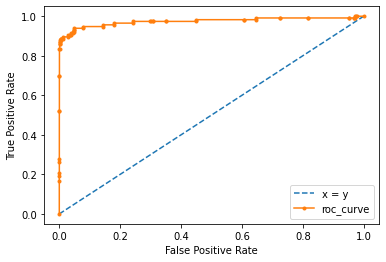



prauc_curve:


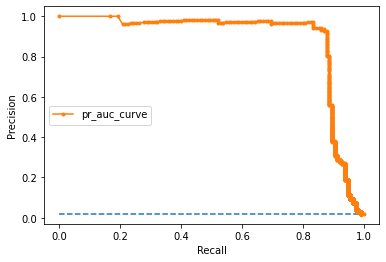

*******
Model name :  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
Best Parameters {'learning_rate': 0.1, 'max_depth': 6, 'n_estimators': 180}
AUC-score : [0.9879900453813497]
Precision-Recall-auc:  [0.918564308980259]
Balanced accuracy score [0.9376152832674571]
Recall : [0.8782608695652174]
Precision : [0.8487394957983193]
F1_score [0.8632478632478634]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5940
           1       0.85      0.88      0.86       115

    accuracy                           0.99      6055
   

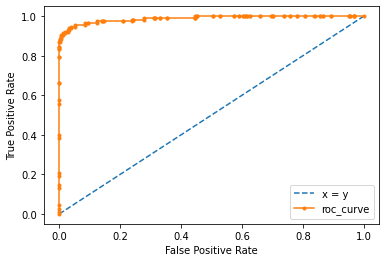



prauc_curve:


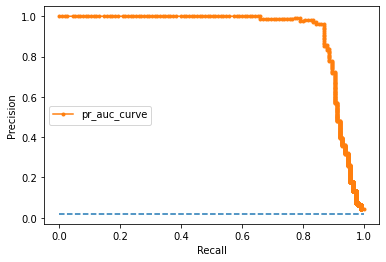

*******
Model name :  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
Best Parameters {'bootstrap': False, 'max_depth': 30, 'min_samples_split': 2, 'n_estimators': 100}
AUC-score : [0.9913358219879959]
Precision-Recall-auc:  [0.9086499919973833]
Balanced accuracy score [0.9300139071878202]
Recall : [0.8608695652173913]
Precision : [0.9519230769230769]
F1_score [0.9041095890410958]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      5940
           

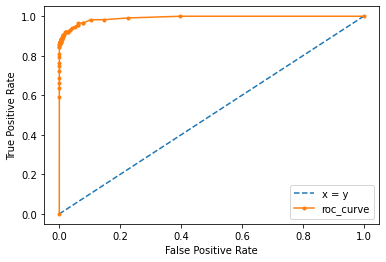



prauc_curve:


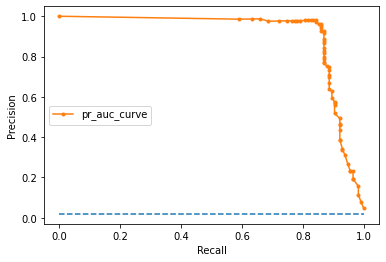

*******


In [ ]:
for i in range(len(models)):
  print("Model name : ", models[i]["Model"])
  fit_score(grid_models[i], x_test_smote.values ,y_test_smote)
  print("*******")

### ANN and SMOTE

#### Keras tuner

In [ ]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Dense(units=hp.Int('units',
                                        min_value=32,
                                        max_value=512,
                                        step=32),
                           activation='relu', input_dim=(x_train_smote.shape[1])))
    for i in range(hp.Int('n_layers', 1, 8)):
        model.add(layers.Dense(hp.Int(f'conv_{i}_units',
                                min_value=32,
                                max_value=256,
                                step=32), activation="relu"))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate',
                      values=[1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model

In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=2,
    directory='LOG_DIR_SMOTE')

In [ ]:
tuner.search(x_train_smote,
            y_train_smote,
             epochs=7,
             batch_size=64,
             validation_data=(x_test_smote, y_test_smote)
            )

Trial 5 Complete [00h 00m 21s]
val_accuracy: 0.9926506876945496

Best val_accuracy So Far: 0.9939719140529633
Total elapsed time: 00h 01m 37s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.get_best_models()[0].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 224)               5600      
_________________________________________________________________
dense_1 (Dense)              (None, 192)               43200     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               24704     
_________________________________________________________________
dense_3 (Dense)              (None, 160)               20640     
_________________________________________________________________
dense_4 (Dense)              (None, 1)                 161       
Total params: 94,305
Trainable params: 94,305
Non-trainable params: 0
_________________________________________________________________


In [ ]:
tuner.get_best_hyperparameters()[0].values

{'conv_0_units': 192,
 'conv_1_units': 128,
 'conv_2_units': 160,
 'conv_3_units': 32,
 'learning_rate': 0.0001,
 'n_layers': 3,
 'units': 224}

In [ ]:
# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

In [ ]:
# Evaluate the best model.
loss, accuracy = best_model.evaluate(X_test_ori.loc[:, randomForestFeatures], y_test_ori)

2671/2671 [==============================] - 5s 2ms/step - loss: 0.0103 - accuracy: 0.9975


In [ ]:
print('the accuracy of the model is : ' ,  accuracy)

the accuracy of the model is :  0.9974134564399719


In [ ]:
predict_proba = best_model.predict_proba(X_test_ori.loc[:, randomForestFeatures])

In [ ]:
precision, recall, _ = precision_recall_curve(y_test_ori, predict_proba)
auc_score = auc(recall, precision)
print("The model prauc_score is {}.".format(auc_score))

The model prauc_score is 0.8168009350966224.


In [ ]:
class_prediction = best_model.predict_classes(X_test_ori.loc[:, randomForestFeatures])

In [ ]:
print(classification_report(class_prediction,y_test_ori))
print(confusion_matrix(class_prediction, y_test_ori))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85104
           1       0.90      0.39      0.55       339

    accuracy                           1.00     85443
   macro avg       0.95      0.70      0.77     85443
weighted avg       1.00      1.00      1.00     85443

[[85089    15]
 [  206   133]]


In [ ]:
history = best_model.fit(x_train_smote,
             y_train_smote,
             epochs=7,
             batch_size=64,
             validation_data=(x_test_smote, y_test_smote))

Epoch 1/7
434/434 [==============================] - 2s 3ms/step - loss: 0.0054 - accuracy: 0.9990 - val_loss: 0.0572 - val_accuracy: 0.9934
Epoch 2/7
434/434 [==============================] - 1s 3ms/step - loss: 0.0047 - accuracy: 0.9990 - val_loss: 0.0631 - val_accuracy: 0.9932
Epoch 3/7
434/434 [==============================] - 1s 3ms/step - loss: 0.0041 - accuracy: 0.9992 - val_loss: 0.0662 - val_accuracy: 0.9941
Epoch 4/7
434/434 [==============================] - 1s 3ms/step - loss: 0.0047 - accuracy: 0.9990 - val_loss: 0.0726 - val_accuracy: 0.9944
Epoch 5/7
434/434 [==============================] - 1s 3ms/step - loss: 0.0028 - accuracy: 0.9995 - val_loss: 0.0742 - val_accuracy: 0.9939
Epoch 6/7
434/434 [==============================] - 1s 3ms/step - loss: 0.0027 - accuracy: 0.9993 - val_loss: 0.0797 - val_accuracy: 0.9941
Epoch 7/7
434/434 [==============================] - 1s 3ms/step - loss: 0.0024 - accuracy: 0.9995 - val_loss: 0.0798 - val_accuracy: 0.9944


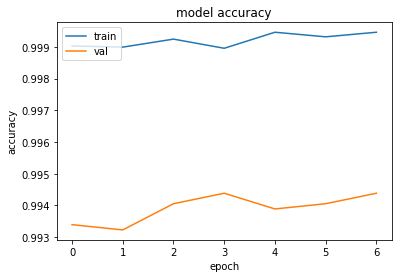

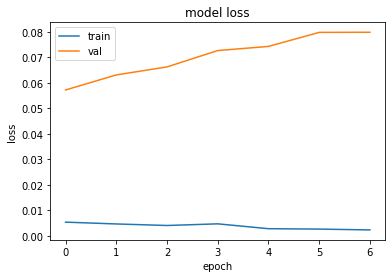

In [ ]:
plotHistory(history, True, True)

In [ ]:
y_pred = best_model.predict_classes(X_test_ori.loc[:, randomForestFeatures])
probs_ov=best_model.predict_proba(X_test_ori.loc[:, randomForestFeatures])
roc = roc_auc_score(y_test_ori, probs_ov)
precision, recall,_ = precision_recall_curve(y_test_ori, probs_ov)
prauc = auc(recall, precision)
balanced_acc = balanced_accuracy_score(y_test_ori,y_pred)   
re = recall_score(y_test_ori, y_pred)
pr = precision_score(y_test_ori, y_pred)
f1 = fbeta_score(y_test_ori,y_pred, beta=1.0)

#### LSTM + Conv1d

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 22, 32)            128       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 11, 32)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               53200     
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 101       
Total params: 53,429
Trainable params: 53,429
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/6
867/867 [==============================] - 6s 5ms/step - loss: 0.3720 - accuracy: 0.8264 - val_loss: 0.1194 - val_accuracy: 0.9863
Epoch 2/6
867/867 [==============================] - 4s 5ms/step - loss: 0.1746 - accuracy: 0.9318 - v

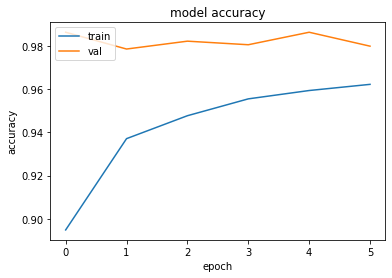

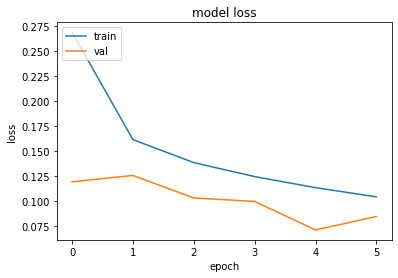

              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85295
           1       0.08      0.89      0.14       148

    accuracy                           0.98     85443
   macro avg       0.54      0.93      0.57     85443
weighted avg       1.00      0.98      0.99     85443

[[83733  1562]
 [   17   131]]


In [ ]:
X_train=x_train_smote.reshape(x_train_smote.shape[0],x_train_smote.shape[1],1)
X_val_test=x_test_smote.to_numpy().reshape(x_test_smote.shape[0],x_test_smote.shape[1],1)
X_test=X_test_ori.loc[:, randomForestFeatures].to_numpy().reshape(X_test_ori.loc[:, randomForestFeatures].shape[0],X_test_ori.loc[:, randomForestFeatures].shape[1],1)
y_train=y_train_smote
val_test=y_test_smote
y_test=y_test_ori.to_numpy()
model = Sequential()
model.add(Conv1D(32,3,activation='relu',input_shape=X_train[0].shape))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics=['accuracy'])
print(model.summary())
history = model.fit(X_train,y_train,epochs=6,validation_data=(X_val_test,val_test))
plotHistory(history, True, True)
class_prediction = model.predict_classes(X_test)
print(classification_report(y_test, class_prediction))
print(confusion_matrix(y_test, class_prediction))

In [ ]:
y_pred = model.predict_classes(X_test)
probs_ov=model.predict_proba(X_test)
roc = roc_auc_score(y_test, probs_ov)
precision, recall,_ = precision_recall_curve(y_test, probs_ov)
prauc = auc(recall, precision)
balanced_acc = balanced_accuracy_score(y_test,y_pred)   
re = recall_score(y_test, y_pred)
pr = precision_score(y_test, y_pred)
f1 = fbeta_score(y_test,y_pred, beta=1.0)

## OverSampling : GANS



In [ ]:
cgans = cGAN(24)

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 512)               12800     
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               32896     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 128)              

In [ ]:
X_gans = X_train_origin.loc[:, randomForestFeatures]
X_gans

,V15,V8,V28,V27,V13,V1,V19,V20,V6,V9,V21,V5,scaled_amount,V2,V18,V7,V16,V3,V12,V11,V4,V17,V10,V14
0,1.468177,0.098698,-0.021053,0.133558,-0.991390,-1.359807,0.403993,0.251412,0.462388,0.363787,-0.018307,-0.338321,1.729682,-0.072781,0.025791,0.239599,-0.470401,2.536347,-0.617801,-0.551600,1.378155,0.207971,0.090794,-0.311169
1,0.635558,0.085102,0.014724,-0.008983,0.489095,1.191857,-0.145783,-0.069083,-0.082361,-0.255425,-0.225775,0.060018,-0.277285,0.266151,-0.183361,-0.078803,0.463917,0.166480,1.065235,1.612727,0.448154,-0.114805,-0.166974,-0.143772
2,2.345865,0.247676,-0.059752,-0.055353,0.717293,-1.358354,-2.261857,0.524980,1.800499,-1.514654,0.247998,-0.503198,4.858216,-1.340163,-0.121359,0.791461,-2.890083,1.773209,0.066084,0.624501,0.379780,1.109969,0.207643,-0.165946
3,-0.631418,0.377436,0.061458,0.062723,0.507757,-0.966272,-1.232622,-0.208038,1.247203,-1.387024,-0.108300,-0.010309,1.372900,-0.185226,1.965775,0.237609,-1.059647,1.792993,0.178228,-0.226487,-0.863291,-0.684093,-0.054952,-0.287924
4,0.175121,-0.270533,0.215153,0.219422,1.345852,-1.158233,0.803487,0.408542,0.095921,0.817739,-0.009431,-0.407193,0.641989,0.877737,-0.038195,0.592941,-0.451449,1.548718,0.538196,-0.822843,0.403034,-0.237033,0.753074,-1.119670
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
198360,-0.371794,0.140304,0.170698,0.304261,0.849049,-0.474163,1.127173,0.138080,-0.207767,-0.903642,0.125517,1.067826,0.426444,1.438815,-0.074010,1.251817,-0.818649,-0.816746,0.161893,-2.023954,0.786791,-0.069831,-0.286039,0.578537
198361,1.050326,0.083778,0.009990,-0.080066,-0.588075,1.501100,-1.176233,-0.004024,-0.208058,0.774633,-0.006746,-2.269449,3.987297,-2.329402,1.677379,-1.307538,-0.595248,-0.028328,-0.628649,-1.313588,-0.579340,-0.276786,0.584604,-0.361347
198362,-0.720134,0.198542,-0.047854,-0.009303,-1.369715,1.957960,-0.018816,-0.279926,0.201289,1.820618,0.199416,-0.685747,-0.117470,-0.677669,-0.018030,-0.854448,-0.270247,-0.395253,-0.201107,-1.677822,0.762448,0.044002,-0.074209,-0.332396
198363,-0.587847,-0.311864,0.084730,-0.198980,-0.184091,-1.135983,-0.962958,1.148427,0.819695,-1.447371,0.522862,-1.936992,10.668078,-2.150924,2.433242,3.101553,-1.307890,-1.078870,-0.251791,-0.033243,-0.922886,-0.691111,-0.418445,0.453033


In [ ]:
y_train_gans = Y_train_origin.values.reshape(-1,1)
pos_index = np.where(y_train_gans==1)[0]
neg_index = np.where(y_train_gans==0)[0]
cgans.train(X_gans.values, y_train_gans, pos_index, neg_index, epochs=2000)

49 [D loss: 0.6099835634231567, acc.: 0.0] [G loss: [0.6913484334945679, 0.53125]]
99 [D loss: 0.49962741136550903, acc.: 0.0] [G loss: [0.7731769680976868, 0.375]]
149 [D loss: -0.23561932146549225, acc.: 0.0] [G loss: [1.2587740421295166, 0.0625]]
199 [D loss: -2.3545907363295555, acc.: 0.0] [G loss: [1.6362900733947754, 0.0]]
249 [D loss: -11.202327743172646, acc.: 0.0] [G loss: [2.753849983215332, 0.0625]]
299 [D loss: -20.010309278964996, acc.: 0.0] [G loss: [4.082024574279785, 0.125]]
349 [D loss: -195.5940980911255, acc.: 0.0] [G loss: [8.649907112121582, 0.1875]]
399 [D loss: -161.42118883132935, acc.: 0.0] [G loss: [13.56938362121582, 0.125]]
449 [D loss: -367.1637268066406, acc.: 0.0] [G loss: [13.75542163848877, 0.3125]]
499 [D loss: -595.2358889877796, acc.: 0.0] [G loss: [38.87437438964844, 0.34375]]
549 [D loss: -708.9516944885254, acc.: 0.0] [G loss: [50.70695114135742, 0.25]]
599 [D loss: -2913.612461090088, acc.: 0.0] [G loss: [85.04220581054688, 0.1875]]
649 [D loss: 

In [ ]:
noise = np.random.normal(0, 1, (3617, 32))
sampled_labels = np.ones(3617).reshape(-1, 1)
gen_samples = cgans.generator.predict([noise, sampled_labels])
gen_samples.shape

(3617, 24)

In [ ]:
data_class_fraud = data_train.loc[data_train['Class'] == 1]
data_class_fraud

,scaled_amount,scaled_time,ID,V1,V2,V3,V4,V5,V6,V7,V8,V9,V10,V11,V12,V13,V14,V15,V16,V17,V18,V19,V20,V21,V22,V23,V24,V25,V26,V27,V28,Class
541,-0.314028,-1.445605,542,-2.312227,1.951992,-1.609851,3.997906,-0.522188,-1.426545,-2.537387,1.391657,-2.770089,-2.772272,3.202033,-2.899907,-0.595222,-4.289254,0.389724,-1.140747,-2.830056,-0.016822,0.416956,0.126911,0.517232,-0.035049,-0.465211,0.320198,0.044519,0.177840,0.261145,-0.143276,1
623,6.911761,-1.444172,624,-3.043541,-3.157307,1.088463,2.288644,1.359805,-1.064823,0.325574,-0.067794,-0.270953,-0.838587,-0.414575,-0.503141,0.676502,-1.692029,2.000635,0.666780,0.599717,1.725321,0.283345,2.102339,0.661696,0.435477,1.375966,-0.293803,0.279798,-0.145362,-0.252773,0.035764,1
4920,2.963256,-1.357565,4921,-2.303350,1.759247,-0.359745,2.330243,-0.821628,-0.075788,0.562320,-0.399147,-0.238253,-1.525412,2.032912,-6.560124,0.022937,-1.470102,-0.698826,-2.282194,-4.781831,-2.615665,-1.334441,-0.430022,-0.294166,-0.932391,0.172726,-0.087330,-0.156114,-0.542628,0.039566,-0.153029,1
6108,0.491873,-1.302778,6109,-4.397974,1.358367,-2.592844,2.679787,-1.128131,-1.706536,-3.496197,-0.248778,-0.247768,-4.801637,4.895844,-10.912819,0.184372,-6.771097,-0.007326,-7.358083,-12.598419,-5.131549,0.308334,-0.171608,0.573574,0.176968,-0.436207,-0.053502,0.252405,-0.657488,-0.827136,0.849573,1
6329,-0.300369,-1.291209,6330,1.234235,3.019740,-4.304597,4.732795,3.624201,-1.357746,1.713445,-0.496358,-1.282858,-2.447469,2.101344,-4.609628,1.464378,-6.079337,-0.339237,2.581851,6.739384,3.042493,-2.721853,0.009061,-0.379068,-0.704181,-0.656805,-1.632653,1.488901,0.566797,-0.010016,0.146793,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
192529,-0.300369,1.361754,192530,-1.396204,2.618584,-6.036770,3.552454,1.030091,-2.950358,-1.528506,0.189319,-1.433554,-5.569142,3.277546,-5.896937,-1.277102,-11.221805,0.326027,-2.497341,-1.588336,0.120289,0.170144,0.031795,0.143177,-0.390176,0.356029,-0.762352,0.096510,-0.487861,0.062655,-0.240732,1
192584,4.638164,1.362253,192585,-2.434004,3.225947,-6.596282,3.593161,-1.079452,-1.739741,-0.047420,0.301424,-1.779434,-5.836453,3.249431,-5.961488,-1.155176,-11.002289,0.588286,-2.365801,-1.351900,0.189498,0.524008,-0.280533,-0.035491,-0.419178,0.157436,-0.714849,0.468859,-0.348522,0.420036,-0.327643,1
192687,3.458271,1.363208,192688,1.522080,-0.519429,-2.581685,0.774741,0.206722,-1.431020,0.757011,-0.444418,0.997921,-1.429490,-0.375466,0.179095,-0.148449,-2.135155,-0.044916,-0.055333,1.778697,0.671832,-0.002021,0.361169,0.019649,-0.211678,-0.247452,-0.279472,0.239646,-0.508398,-0.015551,0.041881,1
195383,9.564540,1.389603,195384,0.469750,-1.237555,-1.767341,4.833490,-0.268715,-0.512760,1.140149,-0.341273,-1.046351,0.085662,-0.000121,-0.054381,0.736192,-2.306645,-0.464003,1.672723,1.165737,0.561323,-2.300798,1.277315,0.303905,-0.647075,-0.373014,0.260801,-0.496566,-0.245973,-0.117858,0.144774,1


In [ ]:
data_fraud_gans= np.concatenate((data_class_fraud.loc[:, randomForestFeatures],gen_samples), axis=0) 

In [ ]:
data_fraud_gans.shape

(4000, 24)

In [ ]:
data_fraud_gans = np.concatenate((data_fraud_gans,np.ones((4000,1))),axis=1)
data_fraud_gans.shape

(4000, 25)

In [ ]:
data_nonfraud_gans= data_train[data_train['Class']==0].sample(n=4000).loc[:, randomForestFeatures]
data_nonfraud_gans['Class']=0
data_nonfraud_gans

,V15,V8,V28,V27,V13,V1,V19,V20,V6,V9,V21,V5,scaled_amount,V2,V18,V7,V16,V3,V12,V11,V4,V17,V10,V14,Class
163935,-0.878357,0.065947,0.079346,0.231161,-1.802338,0.030605,0.364600,-0.130626,-0.616252,-0.005961,-0.255340,0.487921,-0.265264,0.679833,0.094541,0.784394,0.301387,0.112943,-0.258199,0.116866,-0.776345,-0.698637,-0.189572,0.642737,0
46971,-1.360157,-2.228100,0.118817,-0.078967,-0.259286,-0.442463,-0.640054,0.683016,0.972312,0.455530,-1.409851,-0.604275,1.129764,-0.130022,-0.567142,-1.712632,0.403759,1.385767,1.527549,0.675128,-0.741571,-0.143476,-1.418597,0.012851,0
25740,-1.379981,0.310985,0.058053,0.029831,-0.005181,0.790889,0.238470,0.224632,0.553541,1.965503,0.152346,-1.862023,2.083185,-1.144874,-0.118719,-1.097103,-0.321235,1.788052,0.796685,-1.415984,1.267969,0.340096,-0.585787,-1.259222,0
96630,0.948044,-0.029594,0.152243,0.352491,0.213629,-0.527327,0.081394,0.256285,-0.688669,-0.168741,-0.330228,0.236783,-0.251742,1.291105,0.020207,0.698218,0.518818,0.963021,-0.246989,-0.668651,-0.119288,-0.196129,-0.204019,-0.532659,0
173641,-2.382808,-1.926376,0.565417,-0.333338,-0.683249,-3.408431,-0.136624,-3.737423,4.592391,3.325117,-1.086649,-4.447796,16.120885,-3.125394,0.696663,5.329476,0.911938,-0.855108,-0.134105,-0.387583,0.905749,-1.800672,0.829900,-2.666390,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69041,0.421138,0.458468,0.118324,0.013798,0.680710,-0.026118,-0.835932,1.194968,1.937065,-0.045745,0.499082,-1.349225,8.171151,-2.922930,-3.435219,-0.601434,-0.474722,0.392915,0.479190,0.261881,-0.070053,1.879559,-0.112038,-0.775520,0
42211,0.321271,0.274355,0.016541,-0.010230,-1.995630,1.090490,-0.799091,-0.195674,0.173581,-0.374254,0.162860,-0.494298,0.122388,0.149066,0.966407,-0.445132,1.329224,0.875404,-0.669656,0.439671,2.357193,-1.011421,0.891574,0.668814,0
106883,-0.442680,-0.010613,0.124236,0.027834,0.637310,-0.561369,-0.923773,-0.319989,-0.632890,-1.658264,-0.301544,-0.134846,0.262123,-0.114393,1.523693,0.232433,-0.747534,1.383194,0.405992,0.726033,-1.781855,-0.741824,0.168190,0.051522,0
149250,-1.037915,0.728139,0.011328,-0.022796,1.170262,0.079754,0.144302,-0.006513,3.446686,1.864211,0.089228,2.621681,0.641852,-0.015721,-0.193722,0.357987,-0.972255,-1.350254,-2.280851,0.534853,-2.549062,0.652704,-1.601076,1.617690,0


In [ ]:
data_gans= np.concatenate((data_fraud_gans,data_nonfraud_gans), axis=0)
data_gans.shape
type(data_gans)
np.random.shuffle(data_gans)
data_gans.shape

(8000, 25)

In [ ]:
Y_gans=data_gans[:, -1]
X_gans=data_gans[:,:-1]
X_gans.shape

(8000, 24)

In [ ]:
x_train_gan, x_test_gan, y_train_gan, y_test_gan = train_test_split(X_gans,Y_gans, test_size=0.3, stratify=Y_gans, random_state=0)

#### GridSearch Models

In [ ]:
  grid_models =gridSearch(X_gans,Y_gans, models)

Fitting 5 folds for each of 12 candidates, totalling 60 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:    1.8s finished


Fitting 5 folds for each of 96 candidates, totalling 480 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  4.3min
[Parallel(n_jobs=-1)]: Done 446 tasks      | elapsed: 11.1min
[Parallel(n_jobs=-1)]: Done 480 out of 480 | elapsed: 12.4min finished


Fitting 5 folds for each of 72 candidates, totalling 360 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed:  9.5min
[Parallel(n_jobs=-1)]: Done 360 out of 360 | elapsed: 22.5min finished


Model name :  LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Best Parameters {'C': 100, 'penalty': 'l2'}
AUC-score : [0.940914837693664]
Precision-Recall-auc:  [0.6896472158027958]
Balanced accuracy score [0.9021557139530056]
Recall : [0.8243243243243243]
Precision : [0.06670311645708037]
F1_score [0.12341932220536164]
              precision    recall  f1-score   support

           0       1.00      0.98      0.99     85295
           1       0.07      0.82      0.12       148

    accuracy                           0.98     85443
   macro avg       0.53      0.90      0.56     85443
weighted avg       1.00      0.98      0.99     85443

[[83588  1707]
 [   26   122]]


roc_curve:


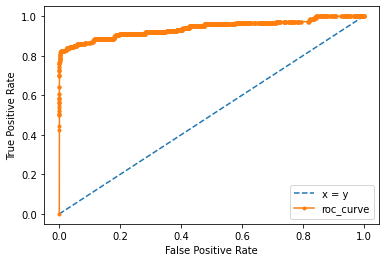



prauc_curve:


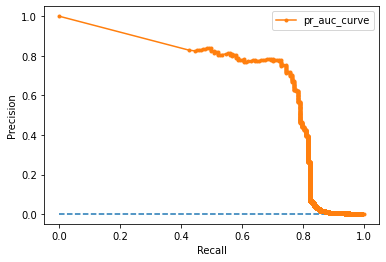

*********
Model name :  XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.1, max_delta_step=0, max_depth=3,
              min_child_weight=1, missing=None, n_estimators=100, n_jobs=1,
              nthread=4, objective='binary:logistic', random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, seed=None,
              silent=None, subsample=1, verbosity=1)
Best Parameters {'learning_rate': 0.1, 'max_depth': 2, 'n_estimators': 180}
AUC-score : [0.9918311329677764]
Precision-Recall-auc:  [0.7987812659641078]
Balanced accuracy score [0.9310665844929285]
Recall : [0.8648648648648649]
Precision : [0.3545706371191136]
F1_score [0.5029469548133596]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.35      0.86      0.50       148

    accuracy                           1.00     85443


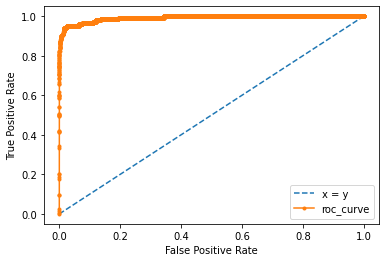



prauc_curve:


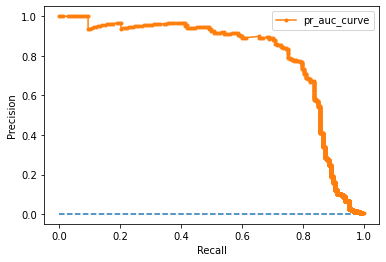

*********
Model name :  RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=0, verbose=0,
                       warm_start=False)
Best Parameters {'bootstrap': False, 'max_depth': 20, 'min_samples_split': 2, 'n_estimators': 200}
AUC-score : [0.9933821490756247]
Precision-Recall-auc:  [0.935951154765316]
Balanced accuracy score [0.9723457380822994]
Recall : [0.9459459459459459]
Precision : [0.5668016194331984]
F1_score [0.7088607594936708]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
          

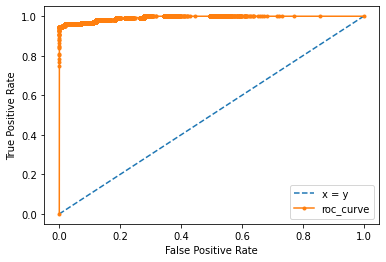



prauc_curve:


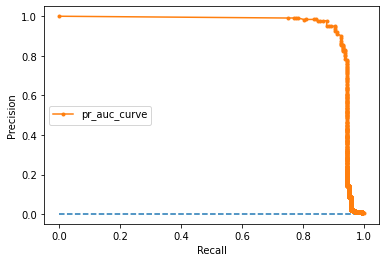

*********


In [ ]:
for i in range(len(models)):
  print("Model name : ", models[i]["Model"])
  fit_score(grid_models[i], X_test_ori.loc[:, randomForestFeatures].values,y_test_ori)
  print("*********")

### ANN with GANS

#### Keras Tuner

In [ ]:
def build_model(hp):
    model = keras.Sequential()
    model.add(layers.Dense(units=hp.Int('units',
                                        min_value=32,
                                        max_value=512,
                                        step=32),
                           activation='relu', input_dim=(X_gans.shape[1])))
    for i in range(hp.Int('n_layers', 1, 10)):
        model.add(layers.Dense(hp.Int(f'conv_{i}_units',
                                min_value=32,
                                max_value=256,
                                step=32), activation="relu"))
    model.add(layers.Dense(1, activation='sigmoid'))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice('learning_rate',
                      values=[1e-2, 1e-3, 1e-4])),
        loss='binary_crossentropy',
        metrics=['accuracy'])
    return model

In [ ]:
tuner = RandomSearch(
    build_model,
    objective='val_accuracy',
    max_trials=5,
    executions_per_trial=2,
    directory='LOG_DIR_GANS')

In [ ]:
tuner.search(x_train_gan,
            y_train_gan,
             epochs=7,
             batch_size=64,
             validation_data=(x_test_gan, y_test_gan)
            )

Trial 5 Complete [00h 00m 05s]
val_accuracy: 0.9918749928474426

Best val_accuracy So Far: 0.9947916567325592
Total elapsed time: 00h 00m 30s
INFO:tensorflow:Oracle triggered exit


In [ ]:
tuner.get_best_models()[0].summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 96)                2400      
_________________________________________________________________
dense_1 (Dense)              (None, 192)               18624     
_________________________________________________________________
dense_2 (Dense)              (None, 128)               24704     
_________________________________________________________________
dense_3 (Dense)              (None, 64)                8256      
_________________________________________________________________
dense_4 (Dense)              (None, 96)                6240      
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 97        
Total params: 60,321
Trainable params: 60,321
Non-trainable params: 0
____________________________________________________

In [ ]:
tuner.get_best_hyperparameters()[0].values

{'conv_0_units': 192,
 'conv_1_units': 128,
 'conv_2_units': 64,
 'conv_3_units': 96,
 'learning_rate': 0.001,
 'n_layers': 4,
 'units': 96}

In [ ]:
# Retrieve the best model.
best_model = tuner.get_best_models(num_models=1)[0]

In [ ]:
# Evaluate the best model.
loss, accuracy = best_model.evaluate(X_test_ori.loc[:, randomForestFeatures],y_test_ori)

2671/2671 [==============================] - 5s 2ms/step - loss: 0.0329 - accuracy: 0.9950


In [ ]:
print('the accuracy of the model is : ' ,  accuracy)

the accuracy of the model is :  0.9952014684677124


In [ ]:
predict_proba_gans = best_model.predict_proba(X_test_ori.loc[:, randomForestFeatures])
precision, recall, _ = precision_recall_curve(y_test_ori, predict_proba_gans)
auc_score = auc(recall, precision)
print("The model prauc_score is {}.".format(auc_score))

The model prauc_score is 0.7267632956703662.


In [ ]:
class_prediction_gans = best_model.predict_classes(X_test_ori.loc[:, randomForestFeatures])
print( classification_report(y_test_ori, class_prediction_gans))
print(confusion_matrix(y_test_ori, class_prediction_gans))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00     85295
           1       0.24      0.84      0.38       148

    accuracy                           1.00     85443
   macro avg       0.62      0.92      0.69     85443
weighted avg       1.00      1.00      1.00     85443

[[84909   386]
 [   24   124]]


In [ ]:
history = best_model.fit(x_train_gan,
             y_train_gan,
             epochs=7,
             batch_size=64,
             validation_data=(x_test_gan, y_test_gan))

Epoch 1/7
88/88 [==============================] - 1s 5ms/step - loss: 0.0255 - accuracy: 0.9934 - val_loss: 0.0213 - val_accuracy: 0.9946
Epoch 2/7
88/88 [==============================] - 0s 3ms/step - loss: 0.0269 - accuracy: 0.9936 - val_loss: 0.0223 - val_accuracy: 0.9946
Epoch 3/7
88/88 [==============================] - 0s 3ms/step - loss: 0.0192 - accuracy: 0.9945 - val_loss: 0.0206 - val_accuracy: 0.9942
Epoch 4/7
88/88 [==============================] - 0s 3ms/step - loss: 0.0193 - accuracy: 0.9941 - val_loss: 0.0226 - val_accuracy: 0.9937
Epoch 5/7
88/88 [==============================] - 0s 4ms/step - loss: 0.0198 - accuracy: 0.9937 - val_loss: 0.0324 - val_accuracy: 0.9917
Epoch 6/7
88/88 [==============================] - 0s 3ms/step - loss: 0.0153 - accuracy: 0.9950 - val_loss: 0.0241 - val_accuracy: 0.9937
Epoch 7/7
88/88 [==============================] - 0s 4ms/step - loss: 0.0136 - accuracy: 0.9952 - val_loss: 0.0265 - val_accuracy: 0.9933


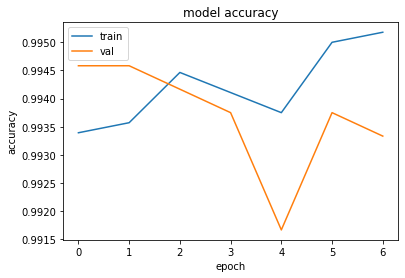

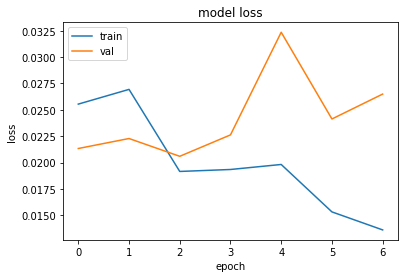

In [ ]:
plotHistory(history, True, True)

In [ ]:
y_pred = best_model.predict_classes(X_test_ori.loc[:, randomForestFeatures])
probs_ov=best_model.predict_proba(X_test_ori.loc[:, randomForestFeatures])
roc = roc_auc_score(y_test_ori, probs_ov)
precision, recall,_ = precision_recall_curve(y_test_ori, probs_ov)
prauc = auc(recall, precision)
balanced_acc = balanced_accuracy_score(y_test_ori,y_pred)   
re = recall_score(y_test_ori, y_pred)
pr = precision_score(y_test_ori, y_pred)
f1 = fbeta_score(y_test_ori,y_pred, beta=1.0)

#### LSTM + Conv1d

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 22, 32)            128       
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 11, 32)            0         
_________________________________________________________________
lstm (LSTM)                  (None, 100)               53200     
_________________________________________________________________
dense_6 (Dense)              (None, 1)                 101       
Total params: 53,429
Trainable params: 53,429
Non-trainable params: 0
_________________________________________________________________
None
Epoch 1/20
175/175 [==============================] - 2s 6ms/step - loss: 0.6727 - accuracy: 0.6980 - val_loss: 0.5532 - val_accuracy: 0.8742
Epoch 2/20
175/175 [==============================] - 1s 4ms/step - loss: 0.4563 - accuracy: 0.8997 -

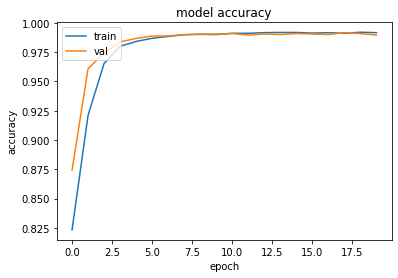

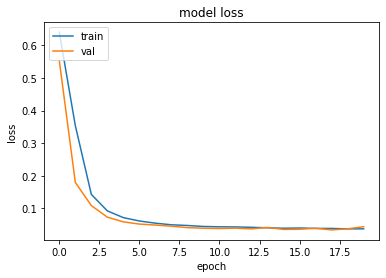

              precision    recall  f1-score   support

           0       1.00      0.99      1.00     85295
           1       0.13      0.84      0.23       148

    accuracy                           0.99     85443
   macro avg       0.57      0.91      0.61     85443
weighted avg       1.00      0.99      0.99     85443

[[84486   809]
 [   24   124]]


In [ ]:
X_train=x_train_gan.reshape(x_train_gan.shape[0],x_train_gan.shape[1],1)
X_val_test=x_test_gan.reshape(x_test_gan.shape[0],x_test_gan.shape[1],1)
X_test=X_test_ori.loc[:, randomForestFeatures].to_numpy().reshape(X_test_ori.loc[:, randomForestFeatures].shape[0],X_test_ori.loc[:, randomForestFeatures].shape[1],1)
y_train=y_train_gan
y_val_test=y_test_gan
y_test=y_test_ori.to_numpy()
model = Sequential()
model.add(Conv1D(32,3,activation='relu',input_shape=X_train[0].shape))
model.add(MaxPooling1D(pool_size=2))
model.add(LSTM(100))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer=Adam(learning_rate=0.0001),loss='binary_crossentropy',metrics=['accuracy'])
print(model.summary())
history = model.fit(X_train,y_train,epochs=20,validation_data=(X_val_test,y_val_test))
plotHistory(history, True, True)
class_prediction = model.predict_classes(X_test)
print(classification_report(y_test, class_prediction))
print(confusion_matrix(y_test, class_prediction))

In [ ]:
y_pred = model.predict_classes(X_test)
probs_ov=model.predict_proba(X_test)
roc = roc_auc_score(y_test, probs_ov)
precision, recall,_ = precision_recall_curve(y_test, probs_ov)
prauc = auc(recall, precision)
balanced_acc = balanced_accuracy_score(y_test,y_pred)   
re = recall_score(y_test, y_pred)
pr = precision_score(y_test, y_pred)
f1 = fbeta_score(y_test,y_pred, beta=1.0)

## Make pipeline

if we run all : the data is all ready scaled so the pipeline will give an error, therefor we have to reexecute the data 

In [ ]:
def pipeline(data):
    rob_scaler = RobustScaler()
    scaled_amount = rob_scaler.fit_transform(data['Amount'].values.reshape(-1,1))
    scaled_time = rob_scaler.fit_transform(data['Time'].values.reshape(-1,1))
    data.insert(0, 'scaled_amount', scaled_amount)
    data.insert(1, 'scaled_time', scaled_time)
    data.drop(['Time','Amount'], axis=1, inplace=True)
    
    randomForestFeatures = randomForestSelector(X_RF, Y_RF, 8)
    
    cgans = cGAN(8)
    X_gans = data.loc[:, randomForestFeatures]
    y_train_gans = data['Class'].values.reshape(-1,1)
    pos_index = np.where(y_train_gans==1)[0]
    neg_index = np.where(y_train_gans==0)[0]
    cgans.train(X_gans.values, y_train_gans, pos_index, neg_index, epochs=2000)
    noise = np.random.normal(0, 1, (3508, 32))
    sampled_labels = np.ones(3508).reshape(-1, 1)
    gen_samples = cgans.generator.predict([noise, sampled_labels])
    data_class_fraud=data.loc[data['Class'] == 1]
    data_fraud_gans= np.concatenate((data_class_fraud.loc[:, randomForestFeatures],gen_samples), axis=0) 
    data_fraud_gans = np.concatenate((data_fraud_gans,np.ones((4000,1))),axis=1)
    data_nonfraud_gans= data[data['Class']==0].sample(n=4000).loc[:, randomForestFeatures]
    data_nonfraud_gans['Class']=0
    data_gans= np.concatenate((data_fraud_gans,data_nonfraud_gans), axis=0)
    np.random.shuffle(data_gans)
    Y_gans=data_gans[:, -1]
    X_gans=data_gans[:,:-1]
    clf = RandomForestClassifier(random_state=0, bootstrap=False, max_depth=20, min_samples_split=2, n_estimators=100)
    clf.fit(X_gans,Y_gans)
    return clf

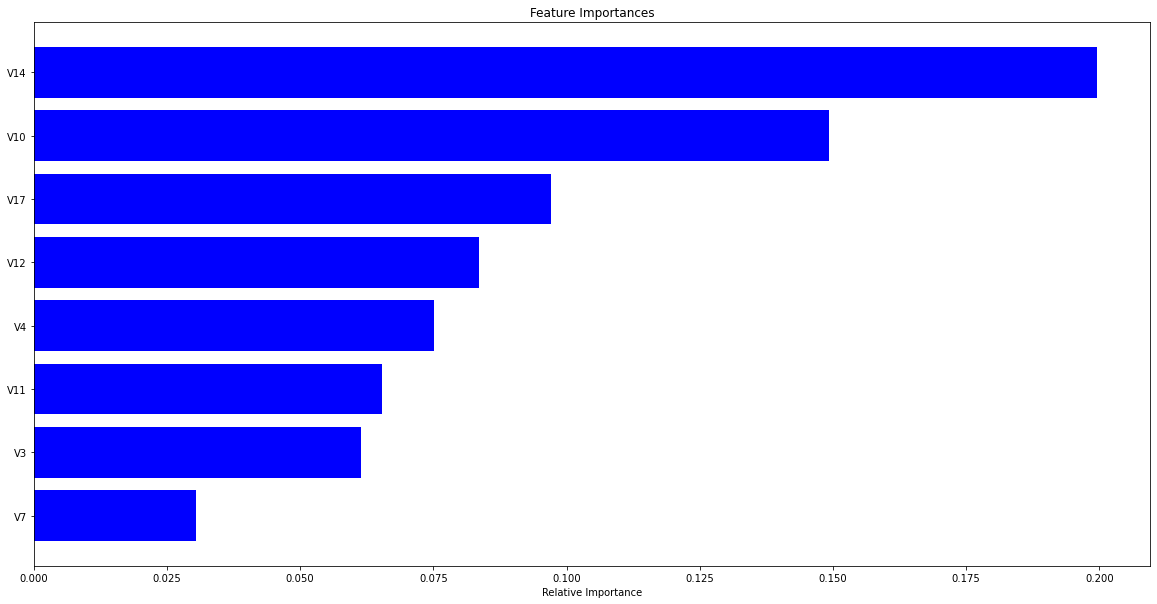

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_7 (Dense)              (None, 512)               4608      
_________________________________________________________________
leaky_re_lu (LeakyReLU)      (None, 512)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 256)               131328    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 256)               0         
_________________________________________________________________
dropout (Dropout)            (None, 256)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 128)               32896     
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 128)              

In [ ]:
pipe = pipeline(data)

In [ ]:
def fit_score2(model,X_test,y_test):
    y_pred = model.predict(X_test)
    probs=model.predict_proba(X_test)
    probs_ov=probs[:,1]

    print('AUC-score :',  [roc_auc_score(y_test, probs_ov)],)
    precision, recall,_ = precision_recall_curve(y_test, probs_ov)
    print("Precision-Recall-auc: ", [auc(recall, precision)])
    print('Balanced accuracy score', [balanced_accuracy_score(y_test,y_pred)])   
    print('Recall :' ,  [recall_score(y_test, y_pred)])
    print( 'Precision :' , [precision_score(y_test, y_pred)],)
    print('F1_score' , [fbeta_score(y_test,y_pred, beta=1.0)])  
    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

    print("\n\nroc_curve:")
    ns_probs = [0 for _ in range(len(y_test))]
    ns_auc = roc_auc_score(y_test, ns_probs)

    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, probs_ov)

    plt.plot(ns_fpr, ns_tpr, linestyle='--', label='x = y')
    plt.plot(lr_fpr, lr_tpr, marker='.', label='roc_curve')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.legend()
    plt.show()

    print("\n\nprauc_curve:")
    x_y = len(y_test[y_test==1]) / len(y_test)
    plt.plot([0, 1], [x_y, x_y], linestyle='--')
    plt.plot(recall, precision, marker='.', label='pr_auc_curve')

    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.legend()
    plt.show()

AUC-score : [1.0]
Precision-Recall-auc:  [1.0]
Balanced accuracy score [0.998593035525853]
Recall : [1.0]
Precision : [0.9259259259259259]
F1_score [0.9615384615384615]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      2843
           1       0.93      1.00      0.96       100

    accuracy                           1.00      2943
   macro avg       0.96      1.00      0.98      2943
weighted avg       1.00      1.00      1.00      2943

[[2835    8]
 [   0  100]]


roc_curve:


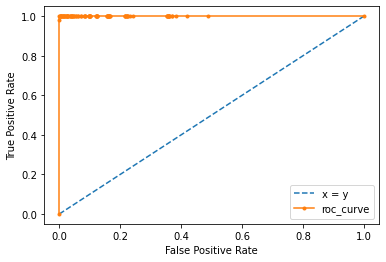



prauc_curve:


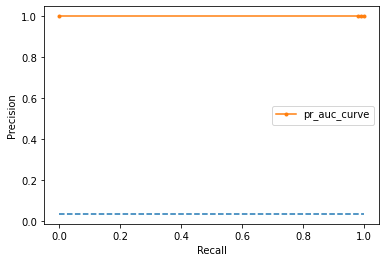

In [ ]:
fit_score2(pipe, x_test_origin_featureselect,y_test_origin)